# DBLP Coauthorship
Credit: Data from SNAP

In [13]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (32.0, 24.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

In [2]:
import torch

import dgl
# Load PyTorch as backend
dgl.load_backend('pytorch')

import networkx as nx

In [3]:
from dgl.data import citation_graph as citegrh

def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.ByteTensor(data.train_mask)
    g = data.graph

    # add self loop
#    g.remove_edges_from(nx.selfloop_edges(g))
#    g = DGLGraph(g)
#    g.add_edges(g.nodes(), g.nodes())
 
    return g, features, labels, mask

In [63]:
[nx_G, features, labels, mask] = load_cora_data()

In [9]:
# Load the DBLP dataset
import pandas as pd

data = pd.read_csv('./data/com-dblp.ungraph.txt.gz', delimiter='\t', skiprows=3)
print(data.shape)
data.head()

nx_G = nx.from_pandas_edgelist(df=data, source='# FromNodeId', target='ToNodeId', create_using=nx.DiGraph())
G = dgl.DGLGraph(nx_G)

(1049866, 2)


DGLError: Error while creating graph from input of type "<class 'networkx.classes.graph.Graph'>".

In [6]:
G = dgl.DGLGraph(nx_G)

In [15]:
print('#Nodes', G.number_of_nodes())
print('#Edges', G.number_of_edges())

#Nodes 2708
#Edges 10556


In [ ]:
nx.draw(nx_G, nx.spectral_layout(nx_G), with_labels=False)

In [18]:
dim_nodes = features.shape[0]
dim_feats = features.shape[1]
print(dim_nodes, dim_feats)

2708 1433


In [21]:
print(labels.unique())
dim_labels = 7

tensor([2, 5, 4, 3, 6, 1, 0])


In [60]:
G.ndata['feat'] = features

In [22]:
import dgl.function as fn

message_func = fn.copy_src(src='h', out='m')
reduce_func = fn.sum(msg='m', out='h')

In [84]:
# Same message function as `fn.copy_u`
def gcn_message_udf(edges):
    return {'m' : edges.src['h']}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(nodes):
    return {'h' : nodes.mailbox['m'].sum(1)}

In [89]:
# Message function with normalization
def gcn_message_udf(g):
    return {'m' : g.src['h'] / torch.sqrt(g.src['norm']).reshape(-1, 1)}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(g):
    return {'h' : g.mailbox['m'].sum(1)}

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# Define the GraphConv module
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.update_all(message_func, reduce_func)
#        # Use normalized functions
#        g.update_all(gcn_message_udf, gcn_reduce_udf)
        # get the result node features
        h = g.ndata.pop('h')
        return h

In [24]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, hidden_size)
        self.gcn2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

In [32]:
print(labels[0:100])
print(list(range(0,100)))

tensor([2, 5, 4, 4, 3, 3, 6, 2, 2, 6, 2, 1, 3, 0, 2, 2, 4, 2, 2, 2, 6, 4, 1, 3,
        4, 6, 2, 3, 2, 5, 0, 2, 0, 2, 4, 4, 2, 4, 1, 4, 6, 3, 1, 2, 0, 4, 2, 0,
        3, 0, 0, 3, 6, 1, 6, 1, 6, 4, 2, 2, 4, 0, 3, 4, 0, 1, 0, 3, 2, 0, 6, 3,
        2, 4, 3, 0, 3, 2, 6, 6, 2, 3, 4, 2, 3, 4, 5, 5, 6, 6, 2, 2, 4, 3, 3, 3,
        0, 2, 6, 3])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [64]:
inputs = torch.eye(dim_nodes)  # featureless inputs
labeled_nodes = torch.tensor(list(range(0,100)))  # take the first 100 nodes as training data
training_labels = labels[0:100]  # their labels are different

In [75]:
net = GCN(dim_nodes, dim_feats, dim_labels)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

all_logits = []
training_losses = []
all_losses = []
for epoch in range(50):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for training data
    training_loss = F.nll_loss(logp[labeled_nodes], training_labels)
    all_loss = F.nll_loss(logp, labels)
    
    training_losses.append(training_loss)
    all_losses.append(all_loss)

    optimizer.zero_grad()
    training_loss.backward()
    optimizer.step()

    print('Epoch %d | Training loss: %.4f; All loss: %.4f' % (epoch, training_loss.item(), all_loss.item()))

Epoch 0 | Training loss: 2.0604; All loss: 1.9475
Epoch 1 | Training loss: 1.9847; All loss: 1.9125
Epoch 2 | Training loss: 1.9141; All loss: 1.8806
Epoch 3 | Training loss: 1.8494; All loss: 1.8523
Epoch 4 | Training loss: 1.7911; All loss: 1.8282
Epoch 5 | Training loss: 1.7392; All loss: 1.8082
Epoch 6 | Training loss: 1.6937; All loss: 1.7921
Epoch 7 | Training loss: 1.6536; All loss: 1.7792
Epoch 8 | Training loss: 1.6182; All loss: 1.7685
Epoch 9 | Training loss: 1.5862; All loss: 1.7590
Epoch 10 | Training loss: 1.5567; All loss: 1.7499
Epoch 11 | Training loss: 1.5289; All loss: 1.7406
Epoch 12 | Training loss: 1.5021; All loss: 1.7306
Epoch 13 | Training loss: 1.4761; All loss: 1.7199
Epoch 14 | Training loss: 1.4506; All loss: 1.7083
Epoch 15 | Training loss: 1.4255; All loss: 1.6961
Epoch 16 | Training loss: 1.4010; All loss: 1.6834
Epoch 17 | Training loss: 1.3770; All loss: 1.6705
Epoch 18 | Training loss: 1.3536; All loss: 1.6575
Epoch 19 | Training loss: 1.3310; All los

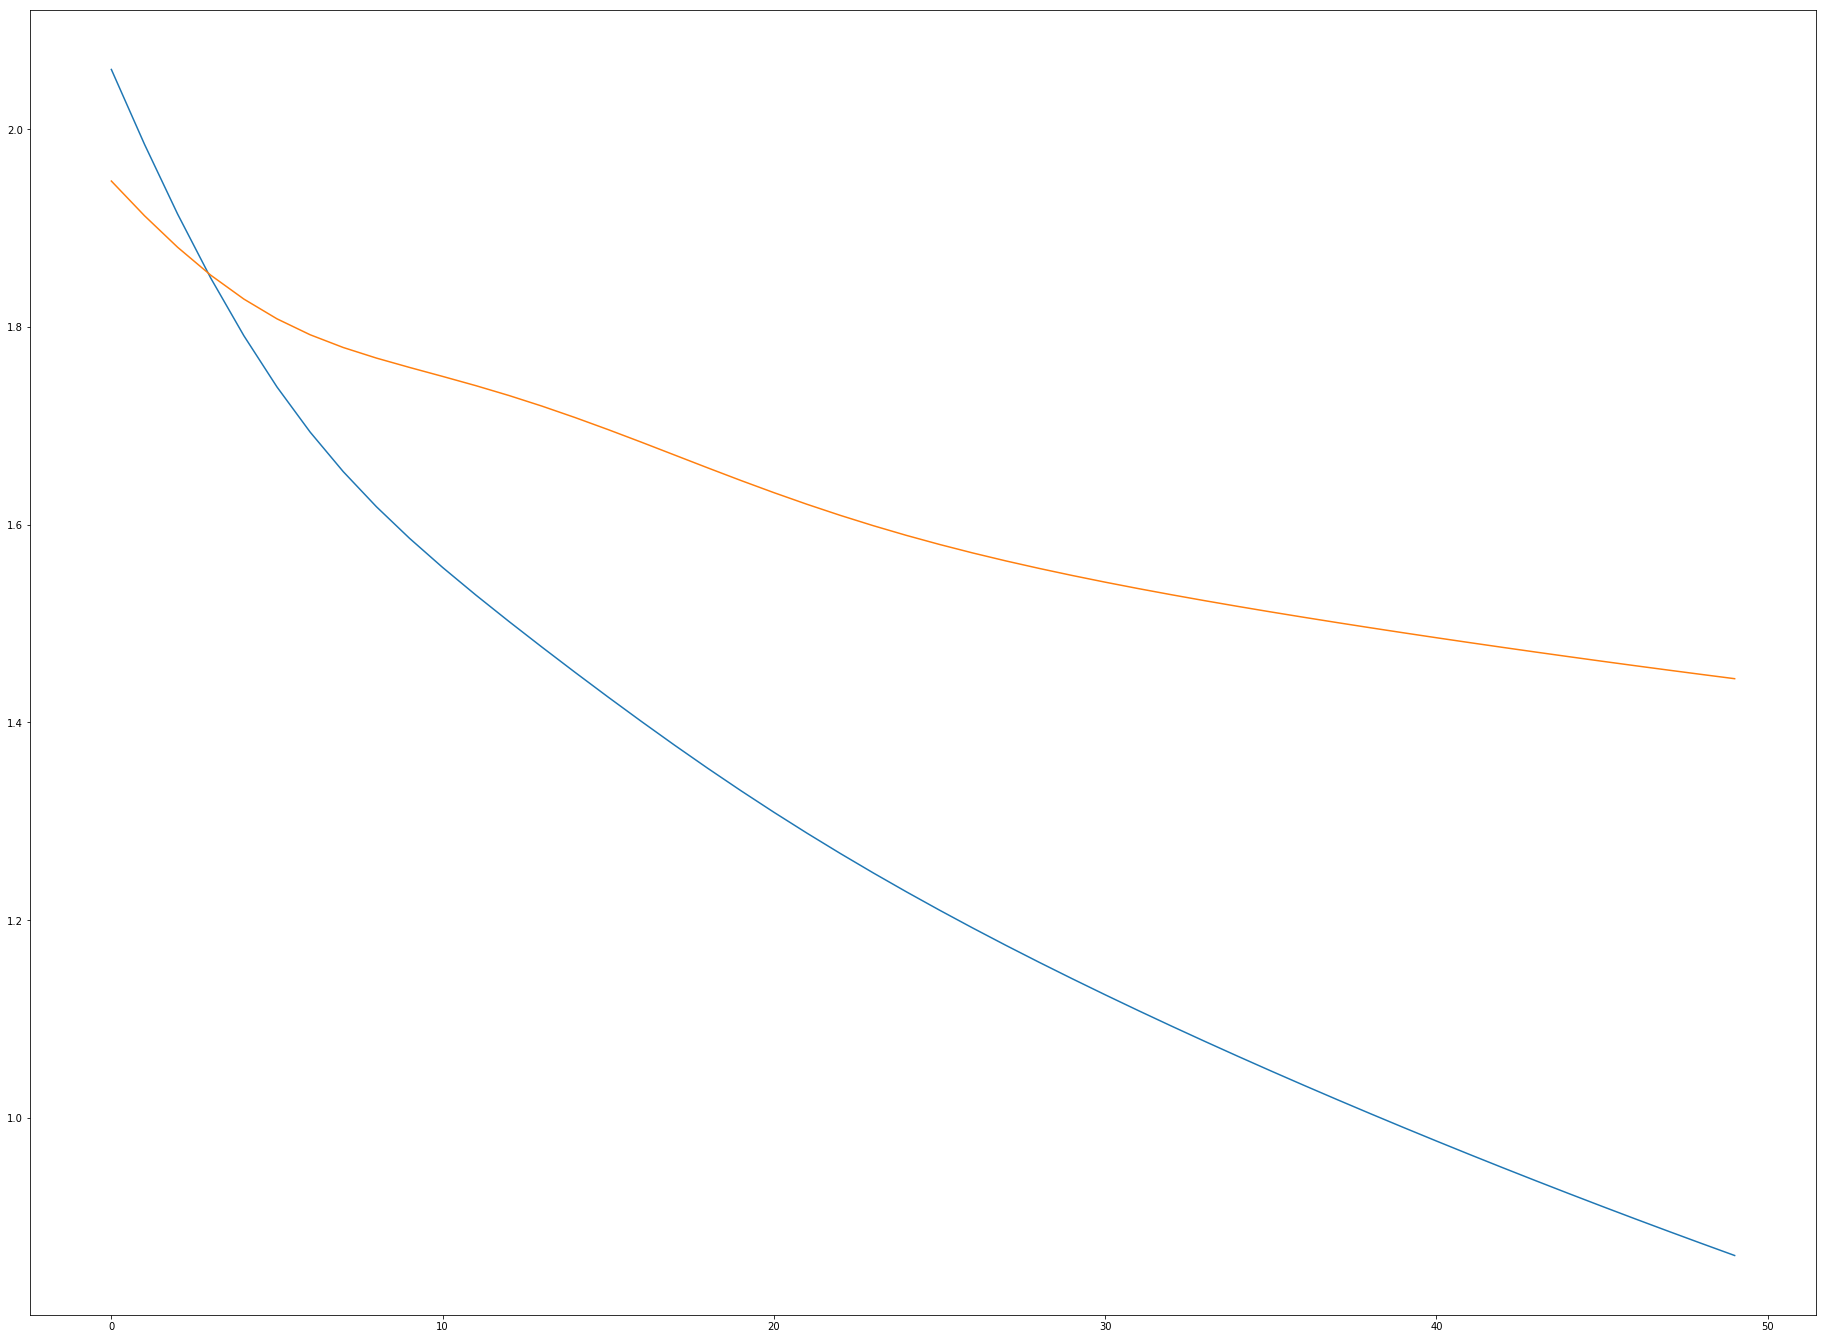

In [76]:
plt.plot(training_losses)
plt.plot(all_losses)

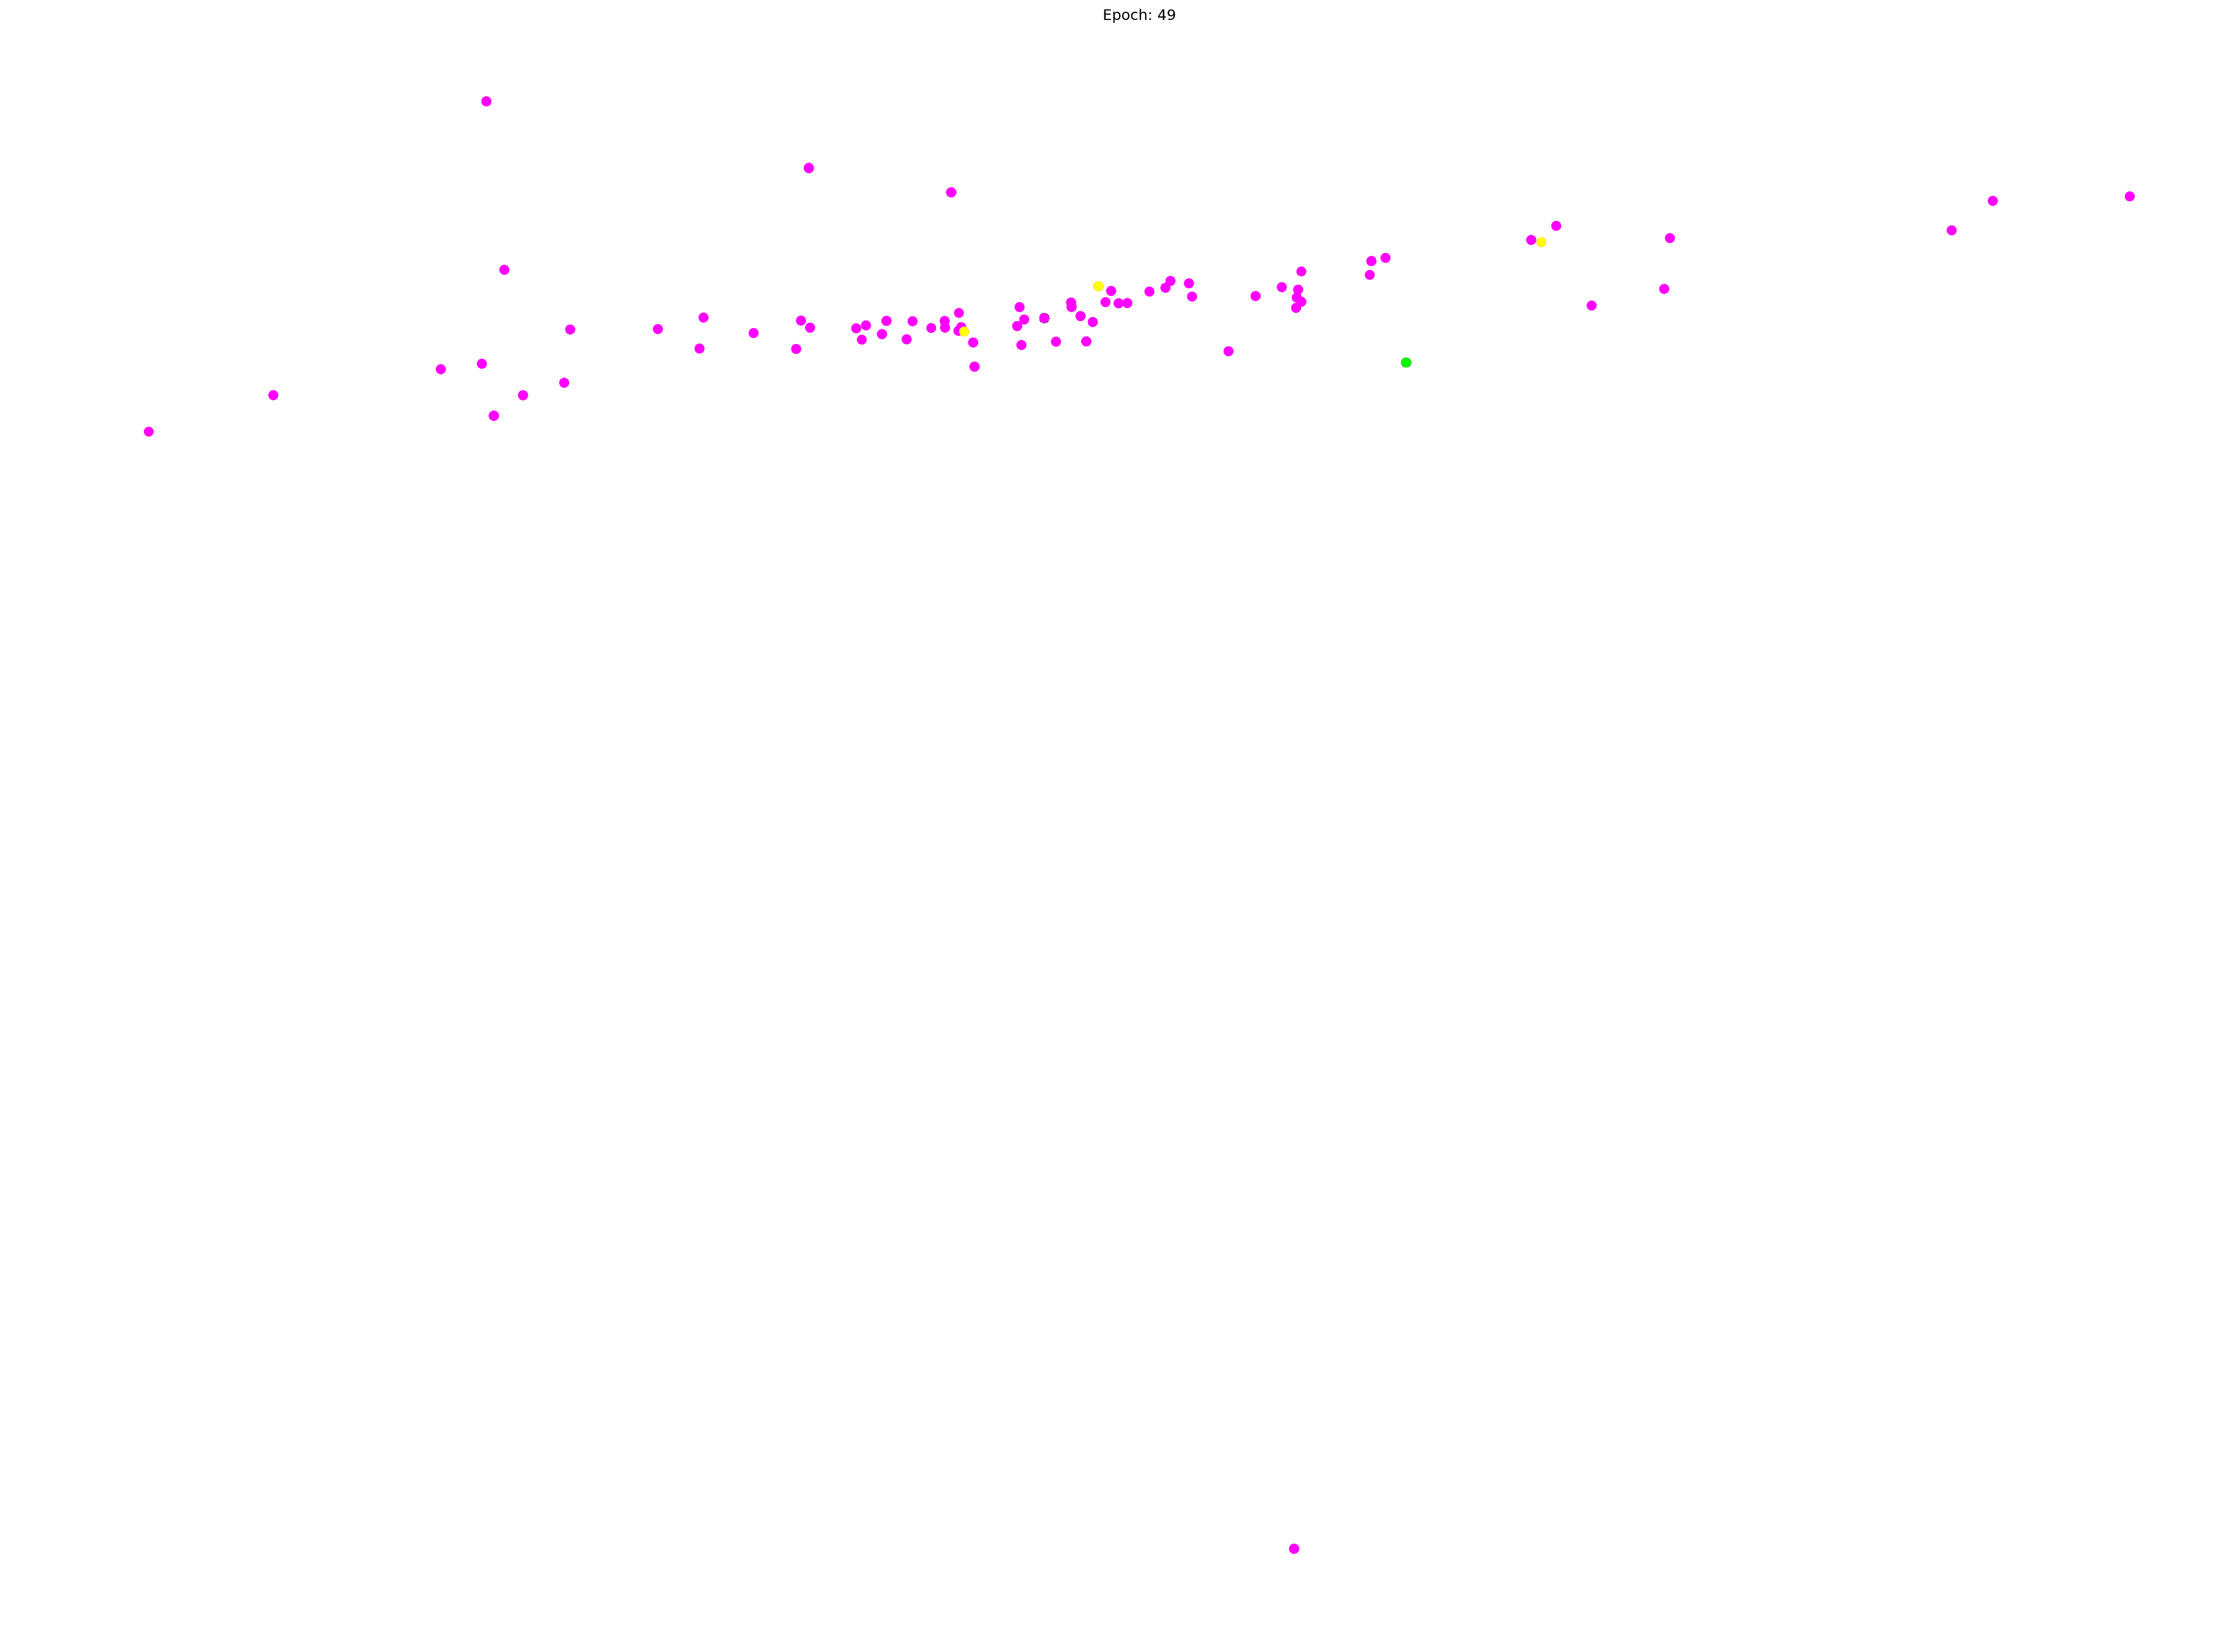

In [77]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()

def draw(i):
    switcher = {
        0: '#FFFF00',
        1: '#00FFFF',
        2: '#FF00FF',
        3: '#0000FF',
        4: '#FF0000',
        5: '#00FF00',
        6: '#000000'
#        othercolor = '#777777'
    }
    
    pos = {}
    colors = []
    for v in range(dim_nodes):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(switcher[cls])

    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), nx.spectral_layout(nx_G), node_color=colors, with_labels=False, node_size=50)

draw(49)
# ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
# HTML(ani.to_html5_video())

In [95]:
results = np.argmax(all_logits[49].numpy(), axis=1)
sum(results[100:] == labels.numpy()[100:]) / (dim_nodes - 100)

0.6054447852760736